# TUTORIAL 4: Cycle GAN
**Author** - [Vuong NGUYEN](https://github.com/XuanMinhVuongNGUYEN)

This tutorial introduces you to the basics of the [Augmentare](https://forge.deel.ai/Fair/augmentare) library to easily use the deployment of Machine Learning techniques to augment data in **PyTorch**. This tutorial mainly explores the core features of library, the predefined losses and the models. 

This tutorial assumes that your system has installed **Pytorch** and **Augmentare** properly.

This tutorial uses the highly popular Cycle GAN or **CycleGAN** architecture. **Augmentare** provides a generalised implementation of **CycleGAN**.

**Paper** - [Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks by Jun-Yan Zhu & al.](https://arxiv.org/abs/1703.10593)

In [1]:
try:
    import augmentare
    print(f"Existing Augmentare {augmentare.__version__} installation found")

except ImportError:
    import subprocess
    import sys

    subprocess.check_call([sys.executable, "-m", "pip", "install", "augmentare"])
    import augmentare

    print(f"Installed Augmentare {augmentare.__version__}")

/home/vuong.nguyen/vuong/augmentare/dev_augmentare/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/vuong.nguyen/vuong/augmentare/dev_augmentare/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/vuong.nguyen/vuong/augmentare/dev_augmentare/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c104impl8GPUTrace13gpuTraceStateE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Existing Augmentare 0.0.1 installation found


## IMPORTS

In [2]:
# General Imports
import glob
import os
import random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Pytorch and Torchvision Imports
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn as nn
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.utils as vutils

# Augmentare Imports
import augmentare
from augmentare.methods.gan import *
from augmentare.plots.plot_losses import plot_losses_gan
from augmentare.plots.plot_samples import plot_image

In [3]:
#Cuda
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## DATA LOADING AND PREPROCESSING
In this tutorial we assume that the dataset is already in our machine. Otherwise you can download the dataset for the CycleGan model using the `download_dataset.sh` file with the `bash ./datasets/download_dataset.sh` command.

This tutorial uses the **Facades** dataset for illustration purposes. We apply the following transformations to the raw dataset to speed up training:

1. For the purposes of this tutorial, we resize the images to $64 \times 64$ and then we use CenterCrop.

2. The images are normalized with a mean and standard deviation of 0.5 for each channel. This has been observed to enable easier training (one can also choose to normalize with the per channel mean and standard deviation).

We then wrap the dataset in a **DataLoader**. Because in the following sections, said **DataLoader** is required to be passed as a parameter while training.

In [4]:
class ImageDataset(Dataset):
    def __init__(self, dataroot, transform = None, unaligned = True, mode="train"):
        """
        Parameters
        ----------
        dataroot
            Path to datatset
        transform
            Image transformations
        unaligned
            The input/output images are unpaired

        Return
        ----------
        Dataset

        """
        self.transform = transform
        self.unaligned = unaligned

        self.file_A = sorted(glob.glob(os.path.join(dataroot, f"{mode}/A") + "/*.*"))
        self.file_B = sorted(glob.glob(os.path.join(dataroot, f"{mode}/B") + "/*.*"))

    def __getitem__(self, index):
        item_A = self.transform(Image.open(self.file_A[index % len(self.file_A)]))

        if self.unaligned:
            item_B = self.transform(Image.open(self.file_B[random.randint(0, len(self.file_B) -1)]))
        else:
            item_B = self.transform(Image.open(self.file_B[index % len(self.file_B)]))
        return {"A": item_A, "B": item_B}

    def __len__(self):
        return max(len(self.file_A),len(self.file_B))

class Load_Data:
    def __init__(self, dataroot, dataset, image_size, batch_size):
        """
        Parameters
        ----------
        dataroot
            Path to datatset
        batch_size
            Batch size
        image_size
            Size of the data crop

        Return
        ----------
        Load dataset

        """
        super(Load_Data,self).__init__()
        self.data_loader = DataLoader(
            ImageDataset(dataroot=os.path.join(dataroot, dataset),
                            transform = transforms.Compose([
                                #transforms.Grayscale(num_output_channels=3), # For horse2zebra dataset
                                transforms.Resize(image_size),
                                transforms.CenterCrop(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]),
                                unaligned=True),
                                batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)

In [5]:
# Dataset
dataloader = Load_Data(dataroot='/home/vuong.nguyen/vuong/data-augmentation-fairness/datasets',
                        dataset='facades',
                        image_size=256, 
                        batch_size=400).data_loader

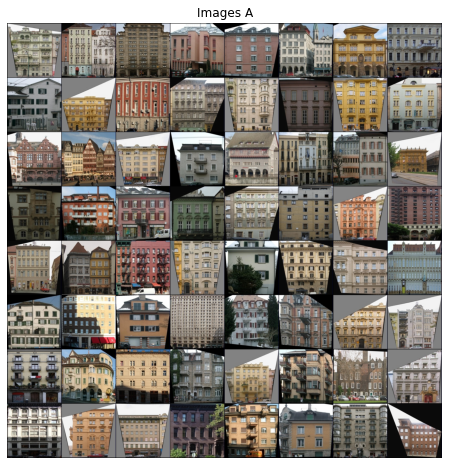

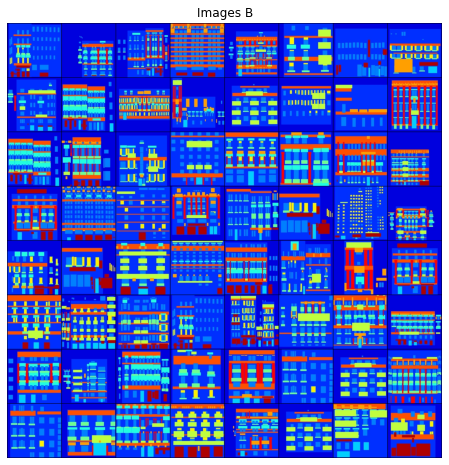

In [6]:
# Visualize the training data
data = next(iter(dataloader))

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Images A")
plt.imshow(
    np.transpose(
        vutils.make_grid(
            data["A"].to(device)[:64], padding=2, normalize=True
        ).cpu(),(1, 2, 0)
    )
)
plt.show()

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Images B")
plt.imshow(
    np.transpose(
        vutils.make_grid(
            data["B"].to(device)[:64], padding=2, normalize=True
        ).cpu(),(1, 2, 0)
    )
)
plt.show()

## NETWORK ARCHITECTURE : CycleGAN

### GENERATOR NETWORK
The CycleGAN Generator has 3 components:

1. A downsampling network: It is composed of 3 convolutional layers  (together with the regular padding, normalization and activation layers).
2. A chain of residual networks built using the Residual Block. You can try to vary the `ResidualBlock` parameter and see the results.
3. A upsampling network: It is composed of 3 transposed convolutional layers.

In CycleGAN Generator, we shall be using **Instance Norm** instead of **Batch Norm** and finally swap the **Zero Padding** of the Convolutional Layer with **Reflection Padding**.

### DISCRIMINATOR NETWORK
The CycleGAN Discriminator is like the standard DCGAN Discriminator. The only difference is the **Instance Normalization** used.

#### CycleGAN Generator

A conditional generator for synthesizing an image given an input image.

In [7]:
net_gen = CYCLEGANGenerator()

#### CycleGAN Discriminator

A discriminator for predicting how likely the generated image is to have come from the target image collection.

In [8]:
net_dis = CYCLEGANDiscriminator()

## OPTIMIZERS AND LOSS FUNCTIONS

The Generator Loss is composed of 3 parts. They are described below:

1. **GAN Loss**: It is the standard generator loss of the Least Squares GAN. We use the functional forms of the losses to implement this part.
$$L_{GAN} = \frac{1}{2} \times ((D_A(G_{B2A}(Image_B)) - 1)^2 + (D_B(G_{A2B}(Image_A)) - 1)^2)$$
2. **Identity Loss**: It computes the similarity of a real image of type B and a fake image B generated from image A and vice versa. The similarity is measured using the $L_1$ Loss.
$$L_{identity} = \frac{1}{2} \times (||G_{B2A}(Image_B) - Image_A||_1 + ||G_{A2B}(Image_A) - Image_B||_1)$$
3. **Cycle Consistency Loss**: This loss computes the similarity of the original image and the image generated by a composition of the 2 generators. This allows cyclegan to deak with unpaired images. We reconstruct the original image and try to minimize the $L_1$ norm between the original images and this reconstructed image.
$$L_{cycle\_consistency} = \frac{1}{2} \times (||G_{B2A}(G_{A2B}(Image_A)) - Image_A||_1 + ||G_{A2B}(G_{B2A}(Image_B)) - Image_B||_1)$$

The Discriminator as mentioned before is same as the normal DCGAN Discriminator. As such even the loss function for that is same as that of the standard GAN:

$$L_{GAN} = \frac{1}{2} \times (((D_A(Image_A) - 1)^2 - (D_A(G_{B2A}(Image_B))^2) + ((D_B(Image_B) - 1)^2 - (D_B(G_{A2B}(Image_A))^2))$$

#### Other Parameters (optimizer, loss function)

**Adam** optimizer is often used to train neural networks, it usually avoids the need for hyperparameter search on parameters like learning rate, etc. **Adam** has hyperparameters that usually don't require much tuning:

-`Learning rate:` or step size. The weightes are updated (e.g. 0.001). A larger value (e.g. 0.3) results in faster initial learning before the rate is updated. Smaller values ​​(eg: 1.0e-5) slow down the learning right during training. Here we set $lr=0.0002$

-`Beta1:` Exponential decay rate for the first time estimate.

-`Beta2:` Exponentially decay rate for second time estimates. This value should be set close to $1.0$ for problems with sparse gradients (e.g. NLP and computer vision problems).

We use **L1Loss** function to minimize the error which is the sum of the all the absolute differences between the true value and the predicted value.

In [9]:
optimizer_gen = Adam(net_gen.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_dis = Adam(net_dis.parameters(), lr=0.0002, betas=(0.5, 0.999))
loss_fn_gen =  nn.L1Loss()
loss_fn_dis =  nn.L1Loss()

#### Create your GAN object

A basic CycleGAN class for training of image-to-image translation model without paired examples.

Parameters:

`generator:` A torch CycleGAN Generator architecture

`discriminator:` A torch CycleGAN Discriminator architecture

`optimizer_gen:` An optimizer for generator

`optimizer_dis:` An optimizer for discriminator

`loss_fn_gen:` A loss function for generator

`loss_fn_dis:` A loss function for discriminator

`device:` Cpu or CUDA

`latent_size:` Size of latent vector (i.e size of generator input)

In [10]:
# Create GAN network
gan = CYCLEGAN(
    net_gen,
    net_dis,
    optimizer_gen,
    optimizer_dis,
    loss_fn_gen,
    loss_fn_dis,
    device,
    latent_size=None
)

## TRAINING THE DCGAN NETWORK

Training the model is quite expensive. Hence, we will train models for 10 epochs if GPU is available, otherwise we will train only for 5 epochs. We should change **num_epochs** so that the model learns to generate good quality images.

Train both generator and discriminator and return the losses.

Parameters:

`subset_a:` Torch.tensor or Dataset

`num_epochs:` The number of epochs you want to train your GAN

`num_decay_epochs:` The number of epochs to start linearly decaying the learning rate to 0 (optional)

`num_classes:` Number of classes in dataset (optional)

`batch_size:` Training batch size (optional)

`subset_b:` The second Torch.tensor or Dataset (optional)

Returns:

`gen_losses, dis_losses:` The losses of both the discriminator and generator

In [11]:
gen_losses, dis_losses = gan.train(
    subset_a=data["A"],
    num_epochs=30,
    num_decay_epochs=15,
    num_classes = None,
    batch_size = None,
    subset_b = data["B"]
)

[1/30][0/400]                             	Loss_D: 1.3109874725341797 	Loss_G: 23.063007354736328
[1/30][50/400]                             	Loss_D: 0.3255488872528076 	Loss_G: 8.667230606079102
[1/30][100/400]                             	Loss_D: 0.7324389219284058 	Loss_G: 7.765220642089844
[1/30][150/400]                             	Loss_D: 1.0504798889160156 	Loss_G: 6.542178630828857
[1/30][200/400]                             	Loss_D: 0.5028231143951416 	Loss_G: 7.708189010620117
[1/30][250/400]                             	Loss_D: 1.497079849243164 	Loss_G: 8.271080017089844
[1/30][300/400]                             	Loss_D: 1.145495891571045 	Loss_G: 6.504088878631592
[1/30][350/400]                             	Loss_D: 0.8543643355369568 	Loss_G: 7.92333984375
[2/30][0/400]                             	Loss_D: 0.5331810116767883 	Loss_G: 6.024600982666016
[2/30][50/400]                             	Loss_D: 0.6082857251167297 	Loss_G: 7.003241539001465
[2/30][100/400]      

#### Plots the Losses

Plots losses for generator and discriminator on a common plot.

Parameters:

`gen_losses:` A list of generator losses
    
`dis_losses:` A list of discriminator losses

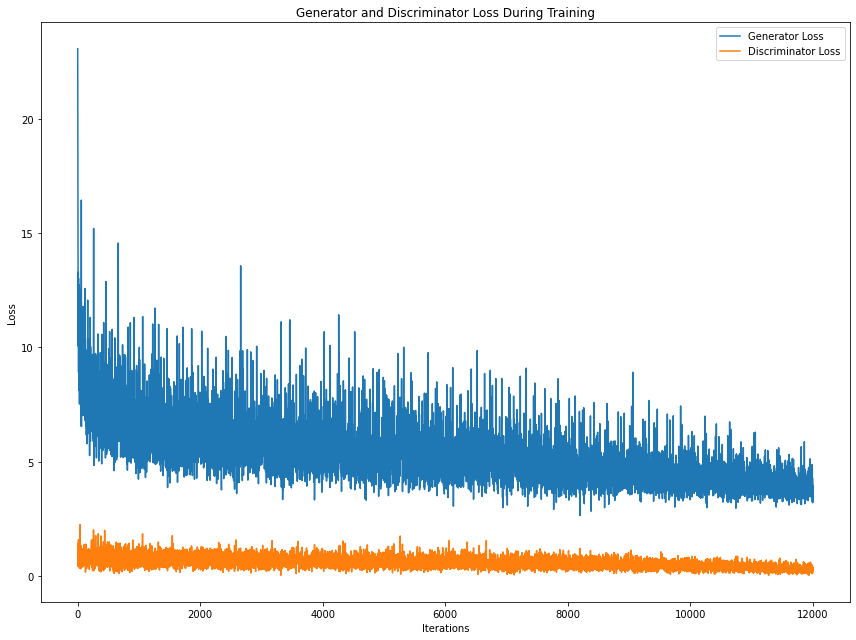

In [12]:
plot_losses_gan(gen_losses,dis_losses)

## VISUALIZE THE GENERATED DATA

#### Sample images from the generator.

Parameters:

`nb_samples:` The number of samples to generate (optional)

`num_classes:` Number of classes in dataset (optional)

`real_image_a:` Real image in subset_a

`real_image_b:` Real image in subset_b

Returns:

`fake_image_a:` A list of generated images A

`fake_image_b:` A list of generated images B

In [13]:
real_a = data["A"][:36]
real_b = data["B"][:36]

fake_image_a, fake_image_b= gan.generate_samples(
    nb_samples = None,
    num_classes = None,
    real_image_a = real_a,
    real_image_b = real_b
)

#### Plots images

Plot a number of generated images with optional label

Parameters:

`img_list:` A list of generated images (Torch tensor)

`number:` Number of images we want to plot

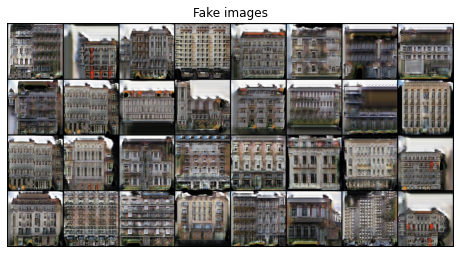

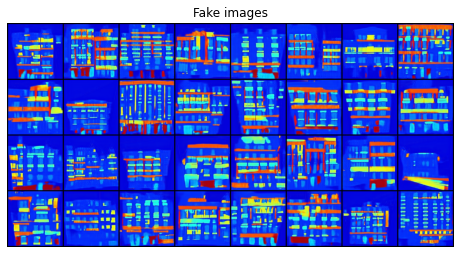

In [14]:
plot_image(fake_image_a, number=32)
plot_image(fake_image_b, number=32)